In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpw965wyn1/pubring.gpg' created
gpg: /tmp/tmpw965wyn1/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/deep_learning/")
os.chdir("./sentiment_classification")
!ls

bow-cnn.hdf5		       polar.vocab
count_vectorizer_weights.hdf5  Sentiment Analysis BOW-CNN.ipynb
data			       Sentiment Analysis BOW_MLP-n-grams.ipynb
data_stopwords		       Sentiment Analysis Embeddings-CNN.ipynb
drive			       Sentiment Analysis Embeddings-MLP.ipynb
mlpv2.py		       X_test_embeddings.pkl
output			       X_train_embeddings.pkl


### Cleaning code does the following
> convert everything to lower case

> handle negations (convert \"don't\" to \"do not\")

> remove tokens that are not alphabetic

> filter stop words

> remove tokens less than 1 character


In [34]:
from string import punctuation
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import re
import keras.backend as K

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleanv2(text):
	# convert to lower case
	text = text.lower()
	# change don't to do not, doesn't to does not
	text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
	# remove remaining tokens that are not alphabetic
	text = re.sub("[^a-zA-Z]", " ", text)
	# tokenize
	tokens = tokenizer.tokenize(text)
	# filter out words less than 1 character
	tokens = [word for word in tokens if len(word) > 1]
	return tokens	

# Function to create or fetch vocabulary
def get_vocab(vocabFile,directory='./sample'): #floyd
	vocabExists = os.path.isfile(vocabFile)
	if vocabExists:
		# Read and return vocab
		print("Found vocab file {}").format(vocabFile)
		vocab = load_doc(vocabFile)
		vocab = vocab.split('\n')
		print("Vocabulary has {} words").format(len(vocab))
	else:
		print("Did not find vocab file {}").format(vocabFile)
		vocab = Counter()
		# walk through all files in the folder
		for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load and clean the doc
				doc = load_doc(filepath)
				tokens = cleanv2(doc)
				vocab.update(tokens)

		print("Number of tokens before filtering freqeuncy of occurance: {}").format(len(vocab))
		vocab = [word for word,freq in vocab.most_common() if freq>2]
		print("Number of tokens occuring more than 2 times: {}").format(len(vocab))
		
		# Save the vocabulary file
		# convert lines to a single blob of text
		data = '\n'.join(vocab)
		# open file
		file = open(vocabFile, 'w+')
		# write text
		print("Saving vocabulary to {}").format(vocabFile)
		file.write(data)
		# close file
		file.close()
	return vocab


# change all files to BoW representation 
# based on frequency of words in each review
# load all docs in a directory into memory
def process_reviews(directory,vocab):
	reviews = list()
	sentiment = list()
	# walk through all files in the folder
	for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load the doc
				doc = load_doc(filepath)
				# clean doc
				tokens = cleanv2(doc)
				# filter by vocab
				tokens = [word for word in tokens if word in vocab]
				review = ' '.join(tokens)
				# append review to reviews
				reviews.append(review)
				# Get the sentiment as well
				sentiment.append(1 if 'pos' in filepath else 0)

	return reviews,sentiment


def get_data(data_file,isTrain=True):
	dataset_type = 'train' if isTrain else 'test'
	if os.path.isfile(data_file):
		print("Found "+dataset_type+" File {}.").format(data_file)
		data = pickle.load(open(data_file, 'rb'))
		X,y = zip(*data)


	else:
		print("Did not find "+dataset_type+" file.")
		vocab = make_vocab('./data_stopwords/polar.vocab','./dataset/train')#floyd
		print("Saved Vocabulary")
		print("processing reviews...")
		X,y = process_reviews('./dataset/'+dataset_type,vocab) #floyd
		data = zip(np.array(X),np.array(y))
		np.array(data).dump('./output/'+dataset_type+'.data') #floyd

	X = np.array(X)
	y = np.array(y)
	print("Found {} samples for "+dataset_type).format(X.shape[0])

	return X,y

def ngram_tokenize(X_train,X_test,max_features=None,ngram=(1,1)):
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(analyzer = "word", 
                               ngram_range = ngram,
                               binary=False, # If True it is frequency else binary
                               max_features = max_features) 
  vectorizer.fit(X_train)
  X_train = vectorizer.transform(X_train)
  X_test = vectorizer.transform(X_test)
  #print vectorizer.vocabulary_
  return X_train,X_test

def train_model(model, X,y,epochs=10):
	from keras.callbacks import ModelCheckpoint
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
	save_model = ModelCheckpoint('weights.hdf5', monitor='val_loss',save_best_only=True)
	hist = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, callbacks=[save_model],validation_data=(X_val,y_val),shuffle=True )
	return hist

def test_model(model, X_test, y_test):
	print("Testing model on {}").format(X_test.shape[0])
	model.load_weights('weights.hdf5') #floyd
	loss, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Test Accuracy: %f' % (acc*100))

def plot_loss(hist):
	import matplotlib.pyplot as plt
	loss = hist.history['loss'] #np.loadtxt('my_cnn_model_loss.csv')
	val_loss = hist.history['val_loss'] #np.loadtxt('my_cnn_model_val_loss.csv')

	plt.plot(loss, linewidth=3, label='train')
	plt.plot(val_loss, linewidth=3, label='valid')
	plt.grid()
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')
	#plt.ylim(1e-3, 1e-2)
	plt.yscale('log')
	plt.show()

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Create Embeddings

In [0]:
# Uses sklearns LabelEncoder API for coverting words to numbers representation
# Changed create_embeddings to get_embeddings, now we can directly fetch the embeddings
def get_embeddingsv2(X_train,X_test,vocab_size,max_length,vocab,stop_words,file_exists):
  
  if file_exists:
    print "Fetching Data"
    if stop_words:
      X_train2 = pickle.load(open('X_train_stop_words_embeddings.pkl', 'rb'))
      X_test2 = pickle.load(open('X_test_stop_words_embeddings.pkl', 'rb'))
    else:
      X_train2 = pickle.load(open('X_train_embeddings.pkl', 'rb'))
      X_test2 = pickle.load(open('X_test_embeddings.pkl', 'rb'))    
    return X_train2,X_test2
  
  from sklearn.preprocessing import LabelEncoder
  from keras.preprocessing.sequence import pad_sequences

  label_encoder = LabelEncoder()
  # Remove words that are not present in the training dataset
  #X_train_full = ' '.join(X_train)
  #X_train_full = X_train_full.split(' ')
  label_encoder.fit(vocab)
  
  print("Vocabulary contains {} words").format(len(label_encoder.classes_))

  print "Encoding training data"
  X_train2 = []
  for i,review in enumerate(X_train):
    X_train2.append(label_encoder.transform(X_train[i].split(' ')))
  
  print "Encoding testing data"  
  X_test2 = []
  for i,review in enumerate(X_test):
    X_test2.append(label_encoder.transform(X_test[i].split(' ')))
    
  print "Padding"
  # pad documents to a max length
  X_train2 = pad_sequences(X_train2, maxlen=max_length, padding='post',truncating='post')
  X_test2 = pad_sequences(X_test2, maxlen=max_length, padding='post',truncating='post')
  
  print "Saving"
  if stop_words:
    np.array(X_train2).dump('X_train_stop_words_embeddings.pkl')
    np.array(X_test2).dump('X_test_stop_words_embeddings.pkl')
  else:
    np.array(X_train2).dump('X_train_embeddings.pkl')
    np.array(X_test2).dump('X_test_embeddings.pkl')
      
  return X_train2,X_test2

## With stop words.

In [36]:
train_file = './data_stopwords/train.data' #floyd
test_file = './data_stopwords/test.data' #floyd
vocab_file = './data_stopwords/polar.vocab'

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)
vocab = get_vocab(vocab_file)

max_length = 500
X,X_test = get_embeddingsv2(X,X_test,len(vocab),max_length,vocab,stop_words=True,file_exists=False)

print(X.shape)
print(X_test.shape)

Found train File ./data_stopwords/train.data.
Found 25000 samples for train
Found test File ./data_stopwords/test.data.
Found 25000 samples for test
Found vocab file ./data_stopwords/polar.vocab
Vocabulary has 37372 words
Vocabulary contains 37372 words
Encoding training data
Encoding testing data
Padding
Saving
(25000, 500)
(25000, 500)


### Trying to do many to one model

#### Vanilla RNN

In [0]:
def vanilla_rnn_modelv1(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout,Flatten, SimpleRNN

	input_layer = Input(shape=(input_shape[1],input_shape[2],))
	x = SimpleRNN(units=32,recurrent_dropout=0.5,dropout=0.5,return_sequences=False,stateful=False)(input_layer)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()

	return model

(25000, 500, 1)
(25000, 500, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500, 1)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/2
 3456/20000 [====>.........................] - ETA: 2:42 - loss: 8.1204 - acc: 0.0052

20000/20000 [==============================] - 207s 10ms/step - loss: 7.9523 - acc: 9.0000e-04 - val_loss: 7.9871 - val_acc: 0.0000e+00
Epoch 2/2
 7584/20000 [==========>...................] - ETA: 2:01 - loss: 7.8955 - acc: 0.0000e+00

20000/20000 [==============================] - 207s 10ms/step - loss: 7.9672 - acc: 0.0000e+00 - val_loss: 7.9871 - val_acc: 0.0000e+00
Testing model on 25000
Test Accuracy: 0.000000


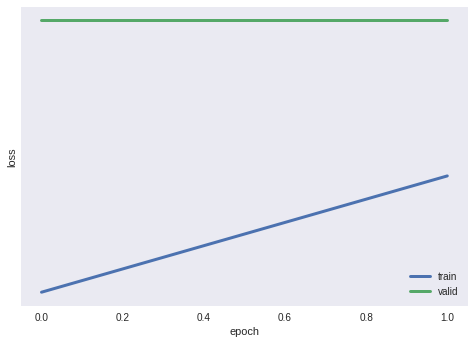

In [39]:
X = X.reshape(X.shape[0],X.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X.shape)
print(X_test.shape)

model = vanilla_rnn_modelv1(input_shape=X.shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=2)
test_model(model,X_test,y_test)
plot_loss(hist)
K.clear_session()

#### LSTM

In [0]:
def LSTM_modelv1(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout,Flatten, LSTM

	input_layer = Input(shape=(input_shape[1],input_shape[2],))
	x = LSTM(units=32,recurrent_dropout=0.5,dropout=0.5,return_sequences=False,stateful=False)(input_layer)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()

	return model